In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from object_detect.convert_detection_image_to_classification_image import obj_to_cls
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
from object_detect.convert_xml_label_to_txt import convert
import shutil


In [2]:
from YoloLoss import *
from ObjectDetectUtils import *
from SwinYOLOClass import *
from DataProcess import *

# data

In [ ]:
# from object_detect.convert_xml_label_to_txt import convert
# import os
# import shutil
# xml_dir = 'linmao-new'
# out_dir = f'{xml_dir}_txt'
# label_map = {'nl_0438': 0,
#              'nl_0431': 1,
#              'nl_0239': 2,
#              'nl_0238': 3,
#              'nl_0271': 4,
#              'nl_0280': 5,
#              'nl_0433': 6,
#              'nl_0224': 7,
#              'nl_0098': 8}
# label_dict = convert(xml_dir, out_dir, label_map, True)
# # see what files we kept
# label_path = []

# for root, dirs, files in os.walk(out_dir):
#     for file in files:
#         if file.endswith(".txt"):
#             the_path = os.path.join(root, file)
#             label_path.append(the_path)
# all_label_names = set([os.path.splitext(i.split(os.sep)[-1])[0] for i in label_path])
# # only keep these images with labels
# image_path = []

# for root, dirs, files in os.walk(xml_dir):
#     for file in files:
#         if file.endswith(".jpg"):
#             the_path = os.path.join(root, file)
#             file_name = os.path.splitext(the_path.split(os.sep)[-1])[0]
#             if file_name in all_label_names:
#                 image_path.append(the_path)

# os.makedirs(os.path.join(out_dir, image_path[0].split(os.sep)[1:-1][0]), exist_ok=True)
# for img_path in image_path:
#     file_name_img = img_path.split('/')[-1]
#     shutil.copy2(img_path, os.path.join(out_dir, image_path[0].split(os.sep)[1:-1][0], file_name_img))

# Generate train test csv

In [3]:
train_images_dir = 'linmao-new_txt/JPEGImages'
test_images_dir = 'linmao-test_txt/JPEGImages'
train_rows = []
test_rows = []

import os
import pandas as pd
for root, dirs, files in os.walk(train_images_dir):
    for file in files:
        if file.endswith(".jpg"):
            if 'checkpoint' in file:
                pass
            else:
                file_path = os.path.join(root, file)
                name = os.path.splitext(file_path.split(os.sep)[-1])[0]
                train_rows.append([name+'.jpg', name+'.txt'])

for root, dirs, files in os.walk(test_images_dir):
    for file in files:
        if file.endswith(".jpg"):
            if 'checkpoint' in file:
                pass
            else:
                file_path = os.path.join(root, file)
                name = os.path.splitext(file_path.split(os.sep)[-1])[0]
                test_rows.append([name+'.jpg', name+'.txt'])
                
                
train_csv = pd.DataFrame(train_rows)
test_csv = pd.DataFrame(test_rows)
train_csv.to_csv('train.csv', index=False, header = False)
test_csv.to_csv('test.csv', index=False, header = False)

# resize data

In [4]:
import os
from tqdm import tqdm

dsize = (320, 320)

train_images_dir = 'linmao-new_txt/JPEGImages'
test_images_dir = 'linmao-test_txt/JPEGImages'

train_save_dir = 'linmao-new_txt/resized/'
test_save_dir = 'linmao-test_txt/resized/'

os.makedirs(train_save_dir, exist_ok=True)
os.makedirs(test_save_dir, exist_ok=True)

print('process train...')
image_path = []
import pandas as pd
for root, dirs, files in os.walk(train_images_dir):
    for file in files:
        if file.endswith(".jpg"):
            if 'checkpoint' in file:
                pass
            else:
                file_path = os.path.join(root, file)
                image_path.append(file_path)
for img_p in tqdm(image_path):
    name = img_p.split(os.sep)[-1]
    src = cv2.imread(img_p)
    frame = cv2.resize(src,dsize)
    cv2.imwrite(os.path.join(train_save_dir, name),frame) 

print('process test...')
image_path = []
import pandas as pd
for root, dirs, files in os.walk(test_images_dir):
    for file in files:
        if file.endswith(".jpg"):
            if 'checkpoint' in file:
                pass
            else:
                file_path = os.path.join(root, file)
                image_path.append(file_path)
for img_p in tqdm(image_path):
    name = img_p.split(os.sep)[-1]
    src = cv2.imread(img_p)
    frame = cv2.resize(src,dsize)
    cv2.imwrite(os.path.join(test_save_dir, name),frame) 


  0%|          | 2/8407 [00:00<07:09, 19.56it/s]

process train...


  0%|          | 2/1047 [00:00<01:10, 14.80it/s]

process test...


100%|██████████| 1047/1047 [01:02<00:00, 16.84it/s]


In [5]:
# from object_detect.box_image_text import plot_box
# plot_box('linmao-new_txt/resized', 'linmao-new_txt/Annotations', 'boxed', thickness=3, filter_diff=True)

In [6]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader


seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
Train_IMG_DIR = "linmao-new_txt/resized"
Train_LABEL_DIR = "linmao-new_txt/Annotations"
Test_IMG_DIR = "linmao-test_txt/resized"
Test_LABEL_DIR = "linmao-test_txt/Annotations"
num_classes = 9
img_size = 320
split_size = 14


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


In [7]:
# note that img_size/window_size should be 32
model = SwinTransformerYOLOv1(img_size=img_size, patch_size=4, embed_dim=96, window_size=int(img_size/32), split_size = split_size, 
                              num_boxes = 2, num_classes=num_classes).to(DEVICE)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# model = SwinTransformerYOLOv1(img_size=img_size, split_size = split_size, 
#                  num_boxes = 2, patch_size=4, num_classes=num_classes)


In [9]:
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
loss_fn = YoloLoss(S=split_size, B=2, C=num_classes, obj_w=2, noobj_w=2, coord_w=1, cls_w=5)

    

In [10]:
# load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)


epoch: 0


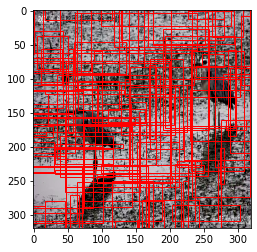

In [ ]:
import pandas as pd
from xin_util.PrettyPrintDict import pretty_print_dict

train_dataset = VOCDataset(
    "train.csv",
    transform=transform,
    img_dir=Train_IMG_DIR,
    label_dir=Train_LABEL_DIR,
    S=split_size, B=2, C=num_classes
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=Test_IMG_DIR, label_dir=Test_LABEL_DIR,
    S=split_size, B=2, C=num_classes
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

save_step = 10

step = 1
for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    train_csv = pd.read_csv('train.csv', header=None)
    sample_df = train_csv.sample(n=3)
    sample_df.to_csv('sample.csv', index=False, header = False)

    sample_dataset = VOCDataset(
        "sample.csv",
        transform=transform,
        img_dir=Train_IMG_DIR,
        label_dir=Train_LABEL_DIR,
        S=split_size, B=2, C=num_classes
    )

    sample_loader = DataLoader(
        dataset=sample_dataset,
        batch_size=2,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for x, y in sample_loader:
        x = x.to(DEVICE)
        for idx in range(1):
            bboxes = cellboxes_to_boxes(model(x), S=split_size, C=num_classes)
            bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
    
    
#     for x, y in train_loader:
#         x = x.to(DEVICE)
#         for idx in range(8):
#             bboxes = cellboxes_to_boxes(model(x))
#             bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
#             plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

#     pred_boxes, target_boxes = get_bboxes(
#         train_loader, model, iou_threshold=0.5, threshold=0.4, S=split_size, C=num_classes
#     )
    
    pred_boxes, target_boxes = get_bboxes(
        test_loader, model, iou_threshold=0.5, threshold=0.4, S=split_size, C=num_classes
    )

    label_wise_precision, label_wise_recall, label_wise_ap, label_wise_pr_curve = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Test mAP:")
    pretty_print_dict(label_wise_ap)
    step+=1
    if step == save_step:
        checkpoint = {
           "state_dict": model.state_dict(),
           "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        step = 0

#     if mean_avg_prec > 0.9:
#        checkpoint = {
#            "state_dict": model.state_dict(),
#            "optimizer": optimizer.state_dict(),
#        }
#        save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
#        import time
#        time.sleep(10)

    train_fn(train_loader, model, optimizer, loss_fn)

In [ ]:
import os
from tqdm import tqdm

dsize = (384, 384)

images_dir = 'linmao-new_txt/JPEGImages'

save_pred_dir = 'swinyolo_pred'
os.makedirs(save_pred_dir, exist_ok=True)



class ComposeImg(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img


transform_img = ComposeImg([transforms.Resize((img_size, img_size)), transforms.ToTensor(),])



image_path = []
import pandas as pd
for root, dirs, files in os.walk(images_dir):
    for file in files:
        if file.endswith(".jpg"):
            if 'checkpoint' in file:
                pass
            else:
                file_path = os.path.join(root, file)
                image_path.append(file_path)
                
for img_p in tqdm(image_path):
    name = os.path.splitext(img_p.split(os.sep)[-1])[0]
    
    image = Image.open(img_p)
    img = transform_img(image)
    img = torch.reshape(img, (1, *img.shape))

    bboxes = cellboxes_to_boxes(model(img), S=split_size, C=num_classes)
    bboxes = [non_max_suppression(box, iou_threshold=0.5, threshold=0.3, box_format="midpoint") for box in bboxes]
    bboxes = bboxes[0] # since we only input one image per run, if it is a bacth we can change this
    save_path = os.path.join(save_pred_dir, name+'.txt')
    with open(save_path, "w+") as f:
        result = []
        for box in bboxes:
            label, conf, x, y, w, h = int(box[0]), box[1], box[2], box[3], box[4], box[5]
            result.append(f"{label} {x} {y} {w} {h} {conf}")
        f.write("\n".join(result))


In [ ]:
label_map = {0: 'nl_0438', 
             1: 'nl_0431', 
             2: 'nl_0239', 
             3: 'nl_0238', 
             4: 'nl_0271', 
             5: 'nl_0280', 
             6: 'nl_0433', 
             7: 'nl_0224', 
             8: 'nl_0098'}

In [ ]:
from object_detect.metrics import label_metrics
pred_txt_dir = 'swinyolo_pred' # runs/detect/combined_yolo_cls/labels
truth_txt_dir = 'linmao-new_txt/Annotations'
lm = label_metrics(pred_txt_dir, truth_txt_dir)
summary_df = lm.get_metrics(iou_thresholds=[0.5], interpolate_pr=True)

In [ ]:
summary_df.label = summary_df.label.replace(label_map)
summary_df

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(131)
x = [str(i) for i in summary_df['label']]
precisions = summary_df['P@0.5'].tolist()
plt.title('precision')
plt.bar(x, precisions)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, precisions[i]+0.01, str(round(precisions[i], 2)), color='blue', fontweight='bold')

plt.subplot(132)
recalls = summary_df['R@0.5'].tolist()
plt.title('recall')
plt.bar(x, recalls)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, recalls[i]+0.01, str(round(recalls[i], 2)), color='blue', fontweight='bold')

plt.subplot(133)
aps = summary_df['AP@0.5'].tolist()
plt.title('average precision')
plt.bar(x, aps)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, aps[i]+0.01, str(round(aps[i], 2)), color='blue', fontweight='bold')

In [ ]:
from object_detect.box_image_text import plot_box

In [ ]:
images_dir

In [ ]:
plot_box(images_dir, 'swinyolo_pred', 'boxed_pred', thickness=3, filter_diff=True)